In [1]:
from os.path import join, dirname, exists
from os import makedirs
from itertools import chain, islice

from thesis_v2 import dir_dict
from thesis_v2.plots.main_results_tables import preprocess

In [2]:
from scipy.stats import sem
import numpy as np

In [3]:
import pandas as pd

In [4]:
def load_ref_results():
    # this does not contain 48, 64 channel results, though.
    # (I forgot to train these models in ensemble mode)
    f_main_result = join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20200725+20200801+20200801_2', 'source_analysis.pkl')
    df_main_result = pd.read_pickle(f_main_result).sort_index()

    assert df_main_result.index.unique
    f_main_result_perf = join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20200725+20200801+20200801_2', 'main_result.pkl')
    df_main_result_perf = pd.read_pickle(f_main_result_perf).sort_index()
    assert df_main_result_perf.index.unique
    
    assert df_main_result.index.equals(df_main_result_perf.index)
    
    return {
        'source_analysis': df_main_result,
        'perf': df_main_result_perf,
    }
results_ref = load_ref_results()

In [5]:
# load 20201114+20201118

# and then merge with cls=1 results from ref.

def load_multipath_results():
    # this does not contain 48, 64 channel results, though.
    # (I forgot to train these models in ensemble mode)
    f_main_result = join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20201114+20201118_sharebn', 'source_analysis.pkl')
    df_main_result = pd.read_pickle(f_main_result).dropna()
    df_main_result_cls1 = results_ref['source_analysis'][results_ref['source_analysis'].index.get_level_values('rcnn_bl_cls')==1]
    df_main_result = pd.concat([df_main_result, df_main_result_cls1], axis=0).sort_index()
    del df_main_result_cls1
    assert df_main_result.index.unique
    f_main_result_perf = join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20201114', 'main_result_sharebn.pkl')
    f_main_result_perf_2 = join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20201118', 'main_result_sharebn.pkl')
    df_main_result_perf = pd.read_pickle(f_main_result_perf).dropna()
    df_main_result_perf_2 = pd.read_pickle(f_main_result_perf_2).dropna()
    
    df_main_result_perf_cls1 = results_ref['perf'][
        results_ref['perf'].index.get_level_values('rcnn_bl_cls')==1
    ]
    
    df_main_result_perf = pd.concat([
        df_main_result_perf, df_main_result_perf_2, df_main_result_perf_cls1,
    ], axis=0).sort_index()
    del df_main_result_perf_2
    del df_main_result_perf_cls1
    assert df_main_result_perf.index.unique
#     print(df_main_result.shape, df_main_result_perf.shape)
    assert df_main_result.index.equals(df_main_result_perf.index)
    
    return {
        'source_analysis': df_main_result,
        'perf': df_main_result_perf,
    }

In [6]:
results_multipath = load_multipath_results()

In [7]:
def remove_high_cls(df_this):
    df_this = df_this[df_this.index.get_level_values('rcnn_bl_cls') <= 7]
    return df_this.sort_index()



In [8]:
def get_normalized_vec(x):
    ret = np.zeros((8,))
    for key, v in x.items():
        assert len(key) >= 2 and len(key) <= 9
        ret[len(key)-2] += v  # -2 because minimal length of key is 2 (I + one Conv)
    ret = ret/ret.sum()
    return ret

# source_analysis_vec_scalar is sum(i*w for i, w in enumerage(vec))
# average depth.

def get_weighted_avg(x):
    assert x.ndim == 1 and x.shape == (8,) and np.all(x >= 0)
    return np.average(np.arange(8), weights=x)



In [9]:
# show mean vs sem, for different cls

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
def get_reduced_data(df_this,strict):
    # do not reduce on anything.
#     axes_to_reduce = ['loss_type', 'ff_1st_bn_before_act', 'model_seed']
    # reduce over model seed, which is purely random.
    axes_to_reduce = ['model_seed']
    columns, df_ff, df_r = preprocess(df_this, axes_to_reduce=axes_to_reduce, max_cls=None,strict=strict)
    return {
        'df_ff': df_ff,
        'df_r': df_r,
        'columns': columns,
    }

In [12]:
# try_pca(df_main_result_reduced_dict['df_r'])
# # 4 dim is enough. ideally I want 1.

In [13]:
def merge_reduced_dict(dict_vec, dict_perf):
    # merge df_r
    assert dict_vec['df_r'].index.equals(dict_perf['df_r'].index)
    df_r = pd.concat([
        dict_vec['df_r'][['source_analysis_vec_mean', 'source_analysis_vec_scalar_mean']],
        dict_perf['df_r'][['cc2_normed_avg_mean']]
    ], axis=1)
    
    # merge df_ff
    
    assert dict_vec['df_ff'].index.equals(dict_perf['df_ff'].index)
    df_ff = pd.concat([
        dict_vec['df_ff'][['source_analysis_vec_mean', 'source_analysis_vec_scalar_mean']],
        dict_perf['df_ff'][['cc2_normed_avg_mean']]
    ], axis=1)
    
    # return 
    return {
        'df_r': df_r,
        'df_ff': df_ff,
    }

In [14]:
def merge_ff_and_r(*, df_r, df_ff):
    df_ff = df_ff.copy()
    df_r_index_values = [
        df_r.index.get_level_values(x) for x in df_ff.index.names
    ]
    df_r_index_values = set(zip(*df_r_index_values))
    
    df_ff = df_ff[df_ff.index.isin(df_r_index_values)]
    
    df_ff['rcnn_bl_cls'] = 1
    df_ff['readout_type'] = 'feedforward'
    df_ff = df_ff.set_index(['rcnn_bl_cls', 'readout_type'], append=True)
    
    assert set(df_r.index.names) == set(df_ff.index.names)
    
    df_ff = df_ff.reorder_levels(
        order=df_r.index.names,
        axis=0
    ).sort_index()
    
    df_merged = pd.concat([df_r, df_ff], axis=0).sort_index()
    assert df_merged.index.is_unique
    return {
        'df_merged': df_merged,
    }
    

In [15]:
def get_merged_dict(dict_this, strict=True):
    
    df_main_result = dict_this['source_analysis']
    df_main_result_perf = dict_this['perf']
    
    df_main_result = remove_high_cls(df_main_result)
    df_main_result_perf = remove_high_cls(df_main_result_perf)

    assert df_main_result.index.equals(df_main_result_perf.index)

    df_main_result['source_analysis_vec'] = df_main_result['source_analysis'].map(lambda x: get_normalized_vec(x))
    df_main_result['source_analysis_vec_scalar'] = df_main_result['source_analysis_vec'].map(lambda x: get_weighted_avg(x))
    del df_main_result['source_analysis']
    
    df_main_result_reduced_dict = get_reduced_data(df_main_result,strict=strict)
    df_main_result_perf_reduced_dict = get_reduced_data(df_main_result_perf,strict=strict)
    
    merged_reduced_dict = merge_reduced_dict(
        df_main_result_reduced_dict,
        df_main_result_perf_reduced_dict
    )
    df_merged_dict = merge_ff_and_r(**merged_reduced_dict)
    
    # to make comparison apple to apple --- many 5 layer models are not available in multi path
    df_merged_dict['df_merged'] = df_merged_dict['df_merged'][df_merged_dict['df_merged'].index.get_level_values('num_layer')==3]
    
    return df_merged_dict

In [16]:
df_merged_dict_ref = get_merged_dict(results_ref)

In [17]:
# sometimes data got lost
df_merged_dict_multipath = get_merged_dict(results_multipath,strict=False)

In [18]:
# let's plot certain specific plots to illustrate my point.
def plot_depth_vs_train_size(df_merged):
    # first, show overall 
    label_list_train_size = df_merged.index.get_level_values('train_keep').unique()
    df_list_train_size = [df_merged.xs(tk, level='train_keep') for tk in label_list_train_size]
    plot_stuff(df_list_train_size, label_list_train_size, 'training data size', subplots=False, plot_line=None)
    
    # then plot histogram for top 10% models.
    plot_hist(
        [
            x.sort_values('cc2_normed_avg_mean',ascending=False)['source_analysis_vec_scalar_mean'].values[:x.shape[0]//10]
            for x in df_list_train_size
        ],
        label_list_train_size,
        'average path depth of top performing models for different train size',
        'average depth'
    )
    
    # then plot histogram for cls=7 models.
    plot_hist(
        [
            x.xs(7, level='rcnn_bl_cls')['source_analysis_vec_scalar_mean'].values
            for x in df_list_train_size
        ],
        label_list_train_size,
        'average path depth of depth 7 models for different train size',
        'average depth'
    )
    
    # then plot histogram for cls=5 models.
    plot_hist(
        [
            x.xs(5, level='rcnn_bl_cls')['source_analysis_vec_scalar_mean'].values
            for x in df_list_train_size
        ],
        label_list_train_size,
        'average path depth of depth 5 models for different train size',
        'average depth'
    )
    

In [19]:
def plot_stuff(df_list, label_list, title, *, subplots, plot_line):
    
    c_list = ['blue', 'orange', 'green', 'red', 'gold']
    assert len(df_list) == len(label_list) <= len(c_list)
    
    plt.close('all')
    
    if not subplots:
        fig, ax = plt.subplots(squeeze=True, figsize=(20, 6),)
    else:
        fig, axes = plt.subplots(nrows=1, ncols=len(df_list), figsize=(20, 6), squeeze=False, sharex=True, sharey=True)
        axes = axes.ravel()
    
    
    
    for idx, (df, label, color) in enumerate(zip(df_list, label_list, c_list)):
        if subplots:
            ax = axes[idx]
    
        ax.scatter(
            df['cc2_normed_avg_mean'].values,
            df['source_analysis_vec_scalar_mean'].values,
            label=str(label), alpha=0.75, s=2, c=color,
        )
        ax.legend(loc='best')
        ax.set_xlabel('perf')
        ax.set_ylabel('depth')
        
        
        if plot_line is not None:
#             line_data = []
            assert isinstance(plot_line, int)
            # cluster data into plot_line clusters according to perf
            perf_data = df['cc2_normed_avg_mean'].values
            depth_data = df['source_analysis_vec_scalar_mean'].values
            idx_arg = np.argsort(perf_data)
            perf_data = perf_data[idx_arg]
            depth_data = depth_data[idx_arg]
            perf_data_avg = np.convolve(perf_data, np.ones((plot_line,))/plot_line, mode='valid')
            depth_data_avg = np.convolve(depth_data, np.ones((plot_line,))/plot_line, mode='valid')
            
#             y_clustering = get_clustering(df['cc2_normed_avg_mean'].values, num_cluster=plot_line)
# #             print(y_clustering)
#             for cluster_idx in range(plot_line):
#                 idx_to_choose = (y_clustering == cluster_idx)
#                 assert np.any(idx_to_choose)
#                 line_data.append((
#                     df['cc2_normed_avg_mean'].values[idx_to_choose].mean(),
#                     df['source_analysis_vec_scalar_mean'].values[idx_to_choose].mean(),
#                 )
#                 )
# #             print(line_data)
#             line_data = sorted(line_data, key=lambda x: x[0])
            ax.plot(perf_data_avg, depth_data_avg, linewidth=2, color=color)
                
        
        if subplots:
            ax.set_title(str(label))
    fig.suptitle(title)
    plt.show()

In [20]:
def plot_hist(values, labels, title, xlabel):
    plt.close('all')
    c_list = ['blue', 'orange', 'green', 'red', 'gold']
    assert len(values) == len(labels) <= len(c_list)
    fig, ax = plt.subplots(squeeze=True, figsize=(10, 6),)
    for value_this, label, color in zip(values, labels, c_list):
        assert value_this.ndim == 1
        value_this_median = np.median(value_this)
        ax.hist(value_this, bins=10, density=True, color=color,
                label='{}, med {:.2f}'.format(label, value_this_median),
                histtype='step')
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel('density')
    fig.suptitle(title)
    plt.show()

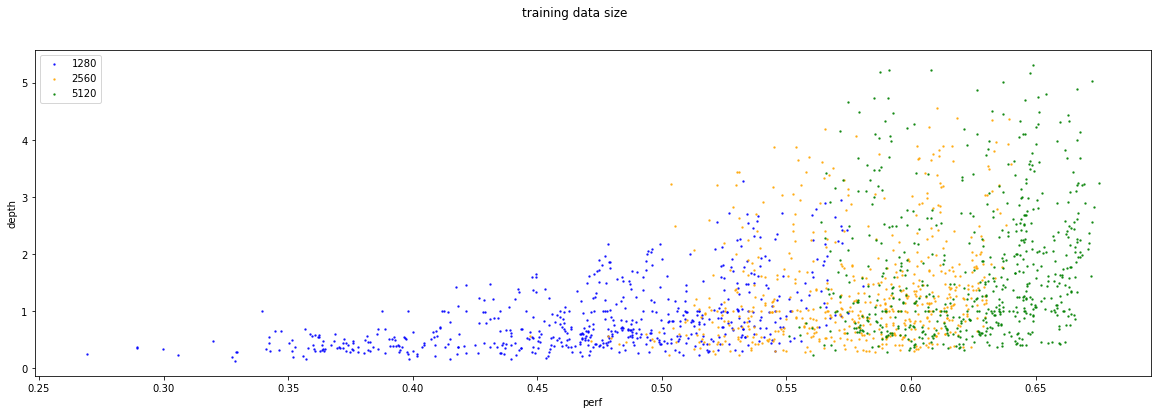

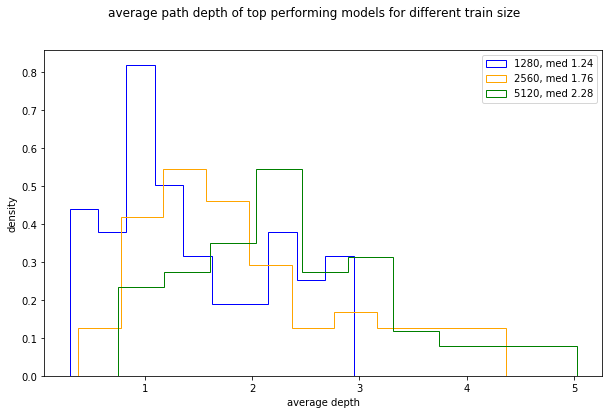

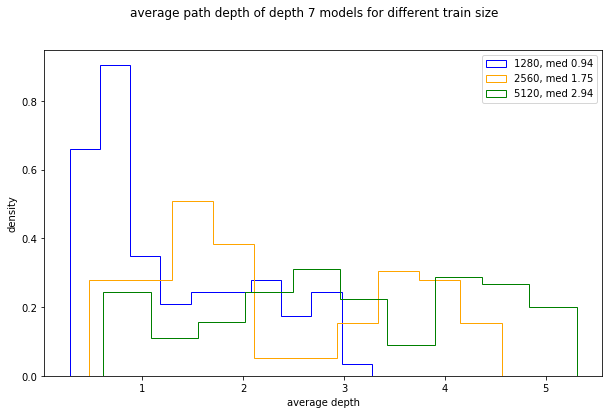

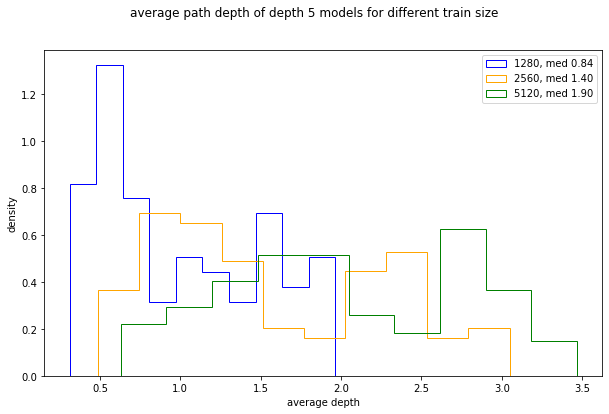

In [21]:
plot_depth_vs_train_size(df_merged_dict_ref['df_merged'])


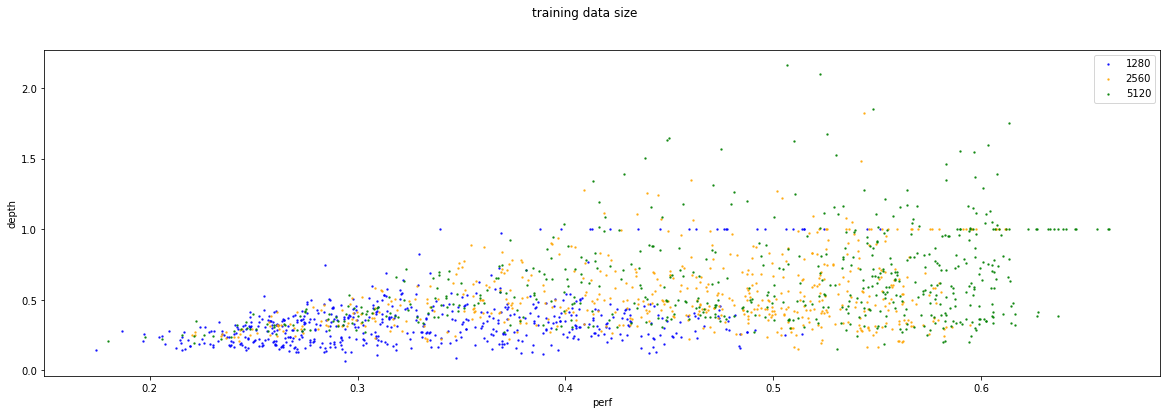

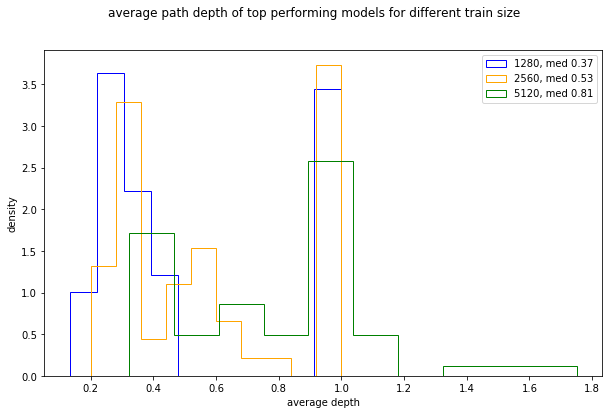

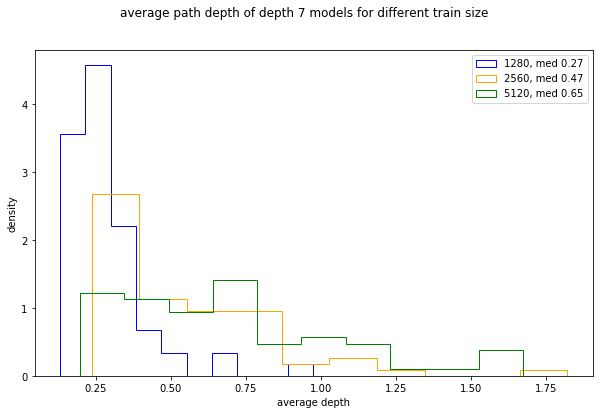

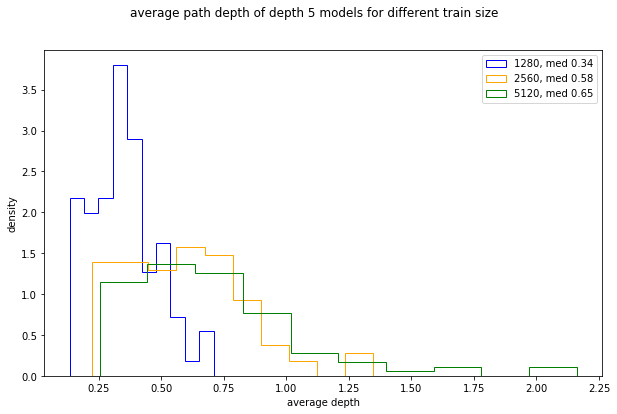

In [22]:
plot_depth_vs_train_size(df_merged_dict_multipath['df_merged'])

In [23]:
# let's plot certain specific plots to illustrate my point.
def plot_depth_vs_out_channel(df_merged):
    label_list_train_size = df_merged.index.get_level_values('train_keep').unique()
    for train_size in label_list_train_size:
        df_merged_this = df_merged.xs(train_size, level='train_keep')
        out_channel_list = df_merged_this.index.get_level_values('out_channel').unique()
        df_list_out_channel = [df_merged_this.xs(tk, level='out_channel') for tk in out_channel_list]
        plot_stuff(df_list_out_channel, out_channel_list, f'train size {train_size}, out channel', subplots=True, plot_line=None)
        
        # then plot histogram for top 10% models.
        plot_hist(
            [
                x.sort_values('cc2_normed_avg_mean',ascending=False)['source_analysis_vec_scalar_mean'].values[:x.shape[0]//10]
                for x in df_list_out_channel
            ],
            out_channel_list,
            f'train size {train_size}, average path depth of top performing models for different out channel',
            'average depth'
        )
    
        # then plot histogram for cls=7 models.
        plot_hist(
            [
                x.xs(7, level='rcnn_bl_cls')['source_analysis_vec_scalar_mean'].values
                for x in df_list_out_channel
            ],
            out_channel_list,
            f'train size {train_size}, average path depth of depth 7 models for different out channel',
            'average depth'
        )
    
        # then plot histogram for cls=6 models.
        plot_hist(
            [
                x.xs(5, level='rcnn_bl_cls')['source_analysis_vec_scalar_mean'].values
                for x in df_list_out_channel
            ],
            out_channel_list,
            f'train size {train_size},average path depth of depth 5 models for different out channel',
            'average depth'
        )
    

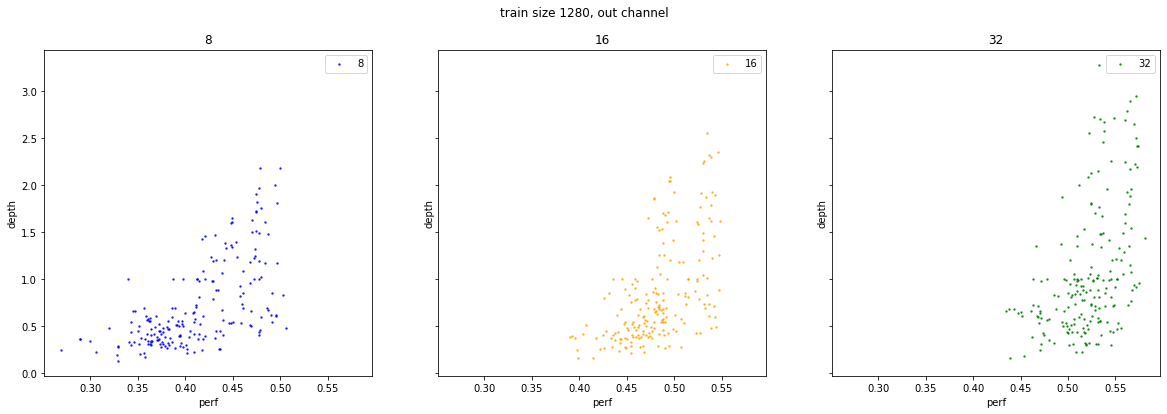

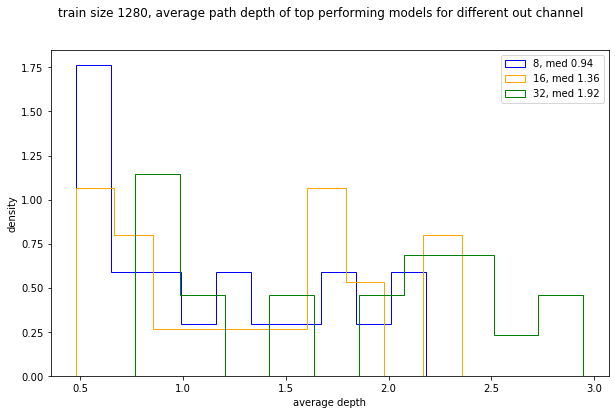

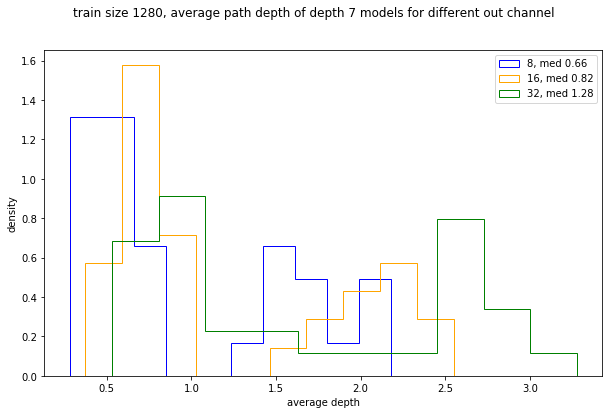

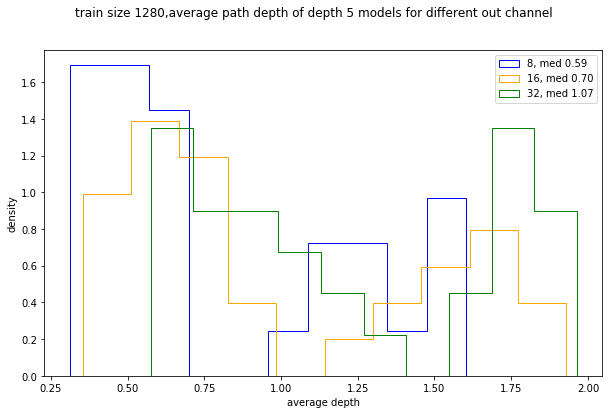

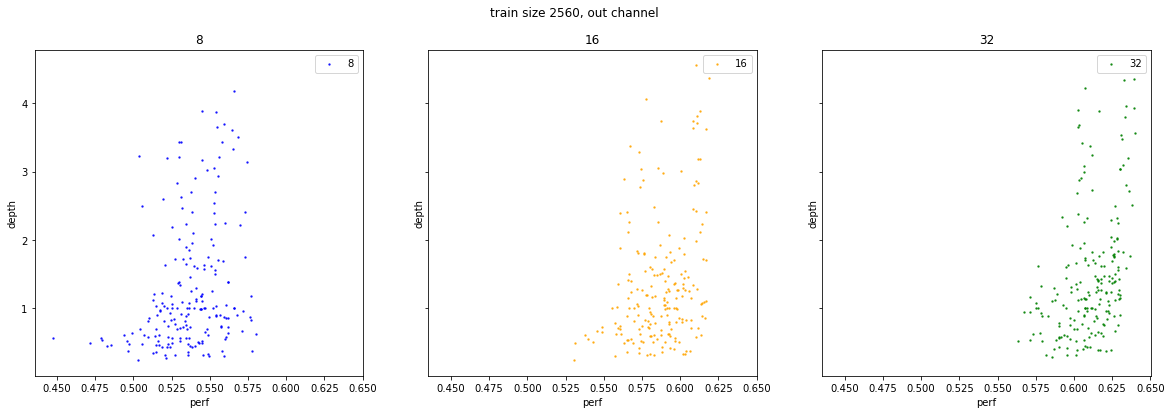

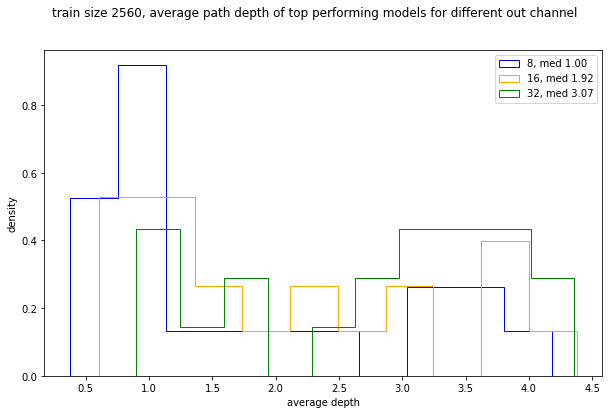

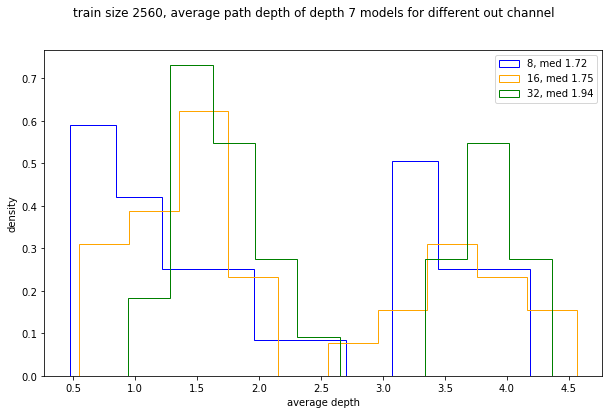

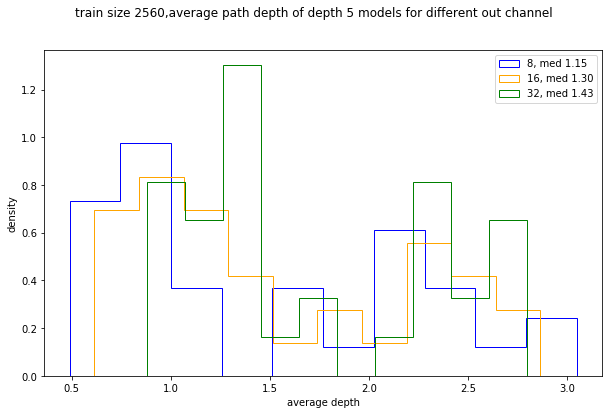

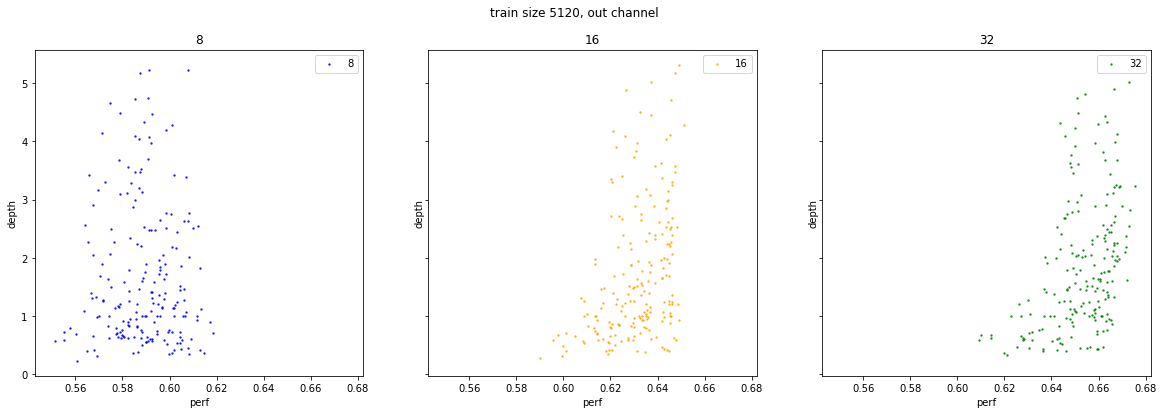

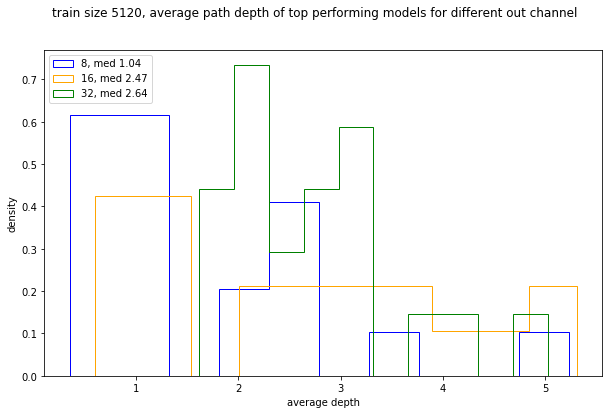

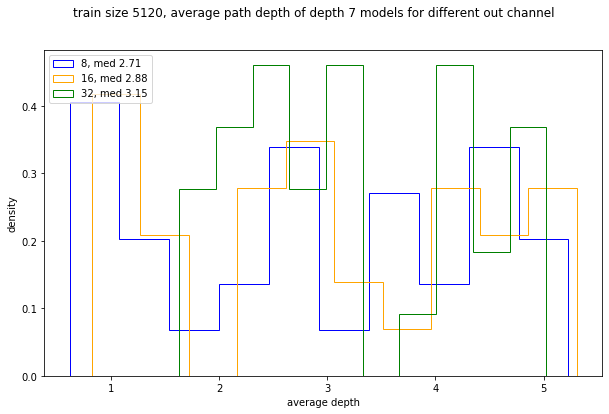

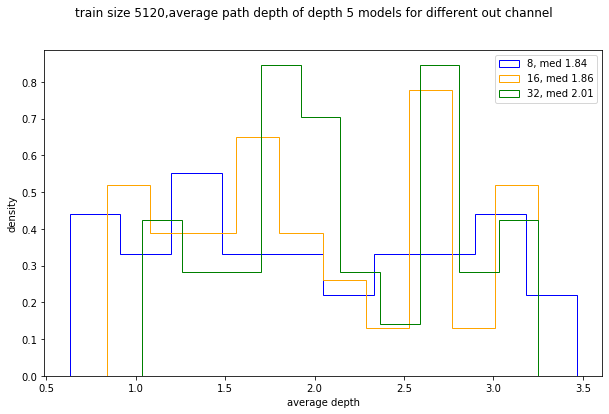

In [24]:
plot_depth_vs_out_channel(df_merged_dict_ref['df_merged'])


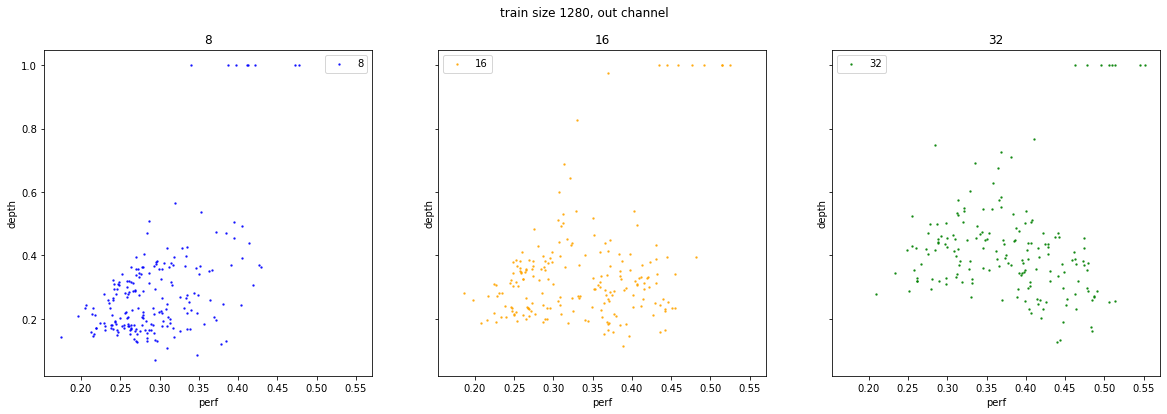

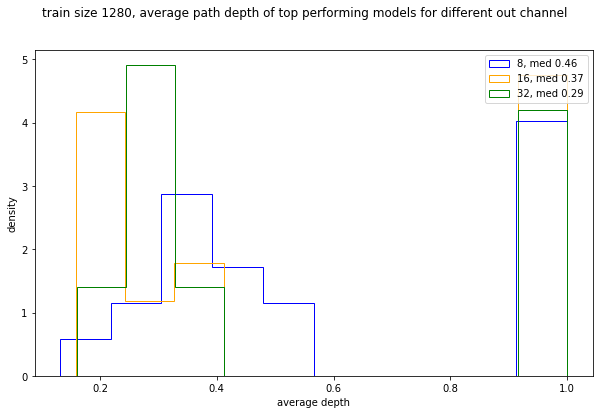

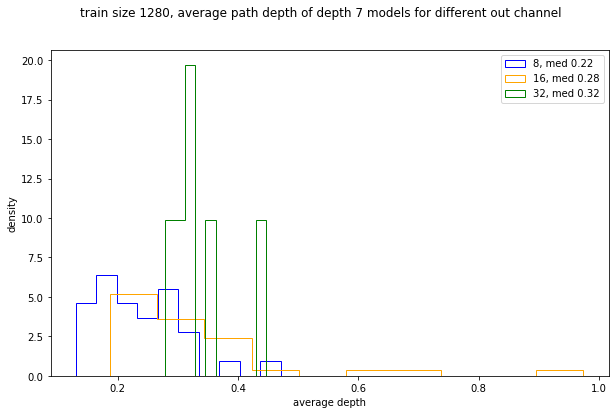

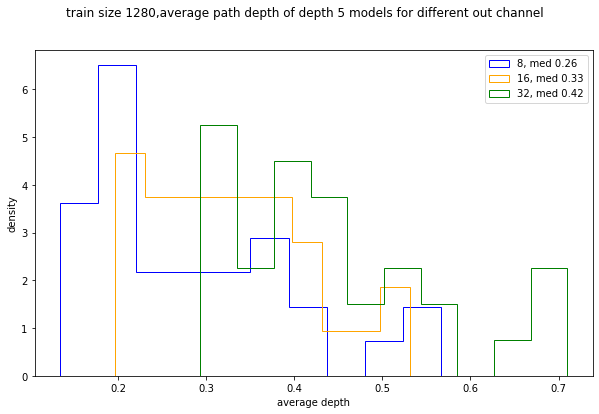

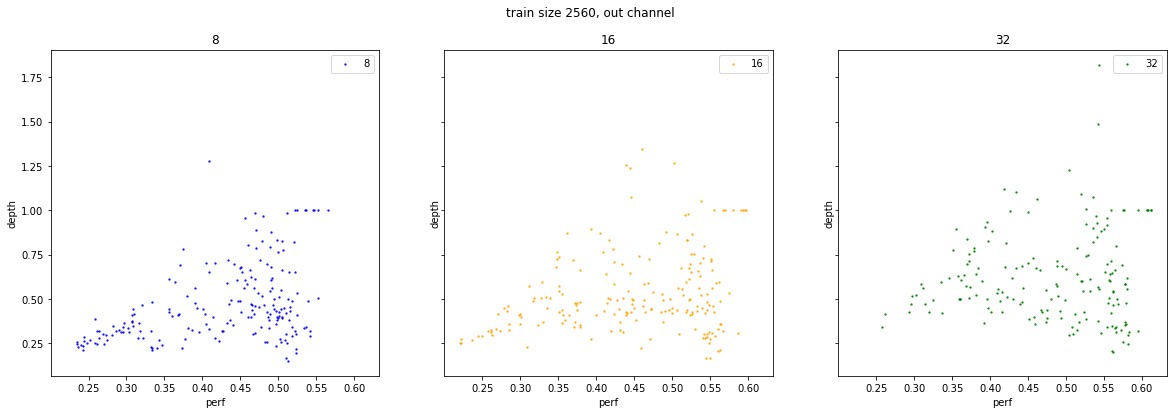

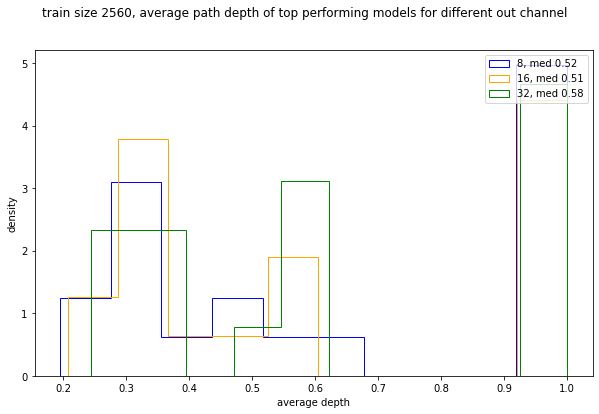

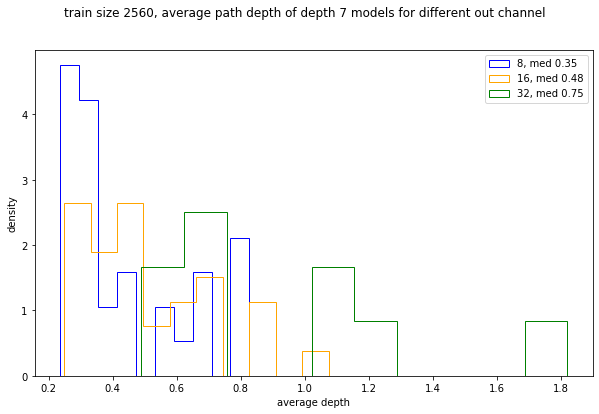

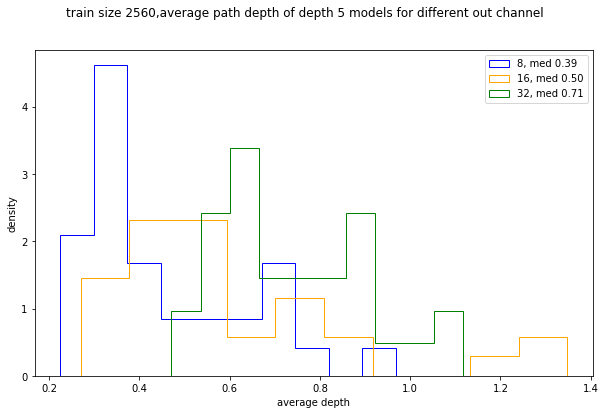

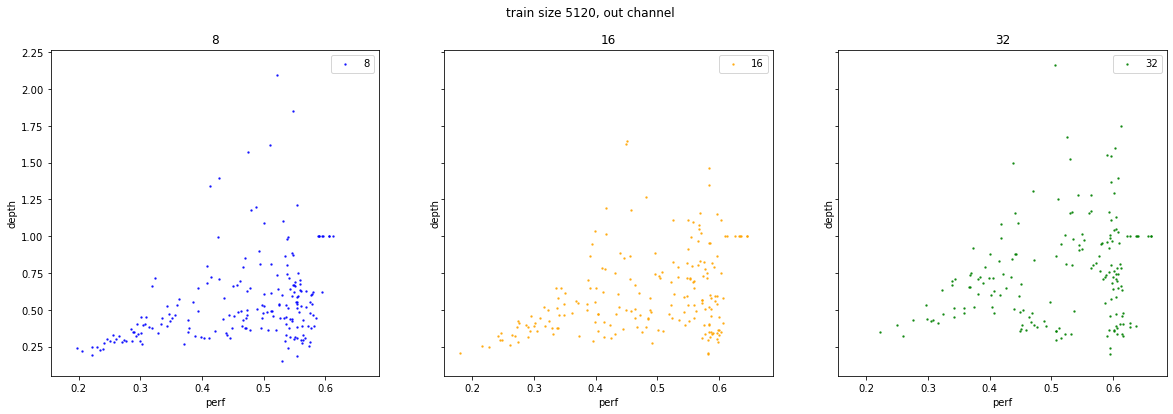

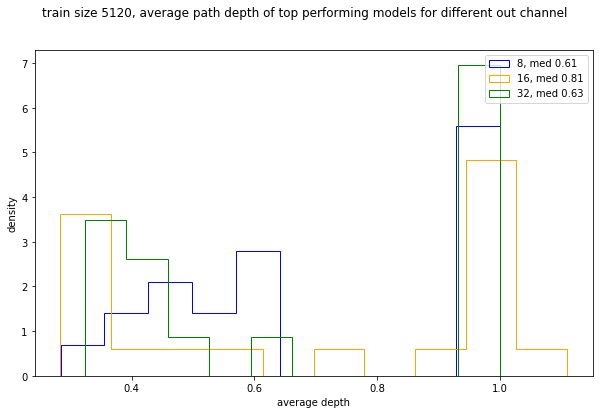

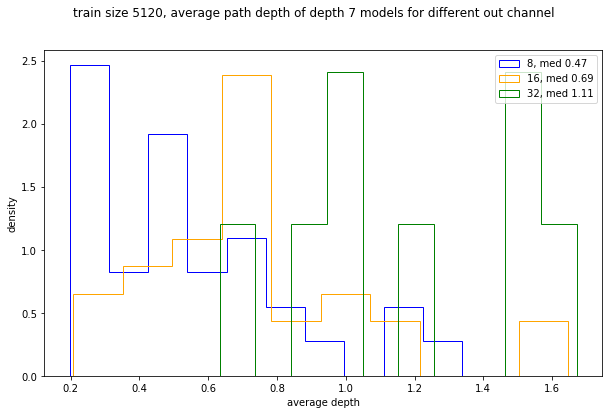

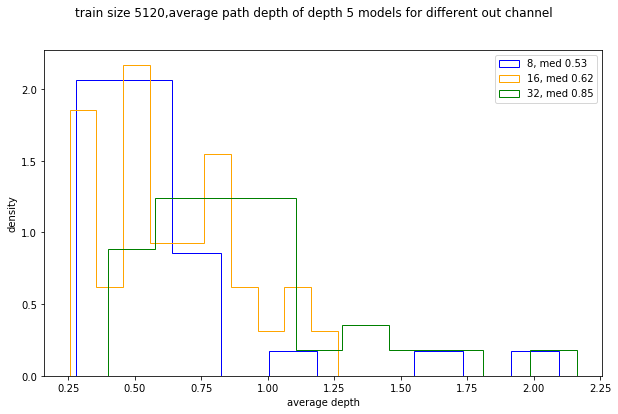

In [25]:
plot_depth_vs_out_channel(df_merged_dict_multipath['df_merged'])

In [26]:
# readout type


# let's plot certain specific plots to illustrate my point.
def plot_depth_vs_readout_type(df_merged):
    label_list_train_size = df_merged.index.get_level_values('train_keep').unique()
    for train_size in label_list_train_size:
        df_merged_this = df_merged.xs(train_size, level='train_keep')
        out_channel_list = df_merged_this.index.get_level_values('readout_type').unique().tolist()
        
        out_channel_list = [x for x in out_channel_list if x != 'feedforward']
        
        df_list_out_channel = [df_merged_this.xs(tk, level='readout_type') for tk in out_channel_list]
        plot_stuff(df_list_out_channel, out_channel_list, f'train size {train_size}, readout_type', subplots=True, plot_line=None)
        
        # then plot histogram for top 10% models.
        plot_hist(
            [
                x.sort_values('cc2_normed_avg_mean',ascending=False)['source_analysis_vec_scalar_mean'].values[:x.shape[0]//10]
                for x in df_list_out_channel
            ],
            out_channel_list,
            f'train size {train_size}, average path depth of top performing models for different readout types',
            'average depth'
        )
    
        # then plot histogram for cls=7 models.
        plot_hist(
            [
                x.xs(7, level='rcnn_bl_cls')['source_analysis_vec_scalar_mean'].values
                for x in df_list_out_channel
            ],
            out_channel_list,
            f'train size {train_size}, average path depth of depth 7 models for different readout types',
            'average depth'
        )
    
        # then plot histogram for cls=6 models.
        plot_hist(
            [
                x.xs(5, level='rcnn_bl_cls')['source_analysis_vec_scalar_mean'].values
                for x in df_list_out_channel
            ],
            out_channel_list,
            f'train size {train_size},average path depth of depth 5 models for different readout types',
            'average depth'
        )
    

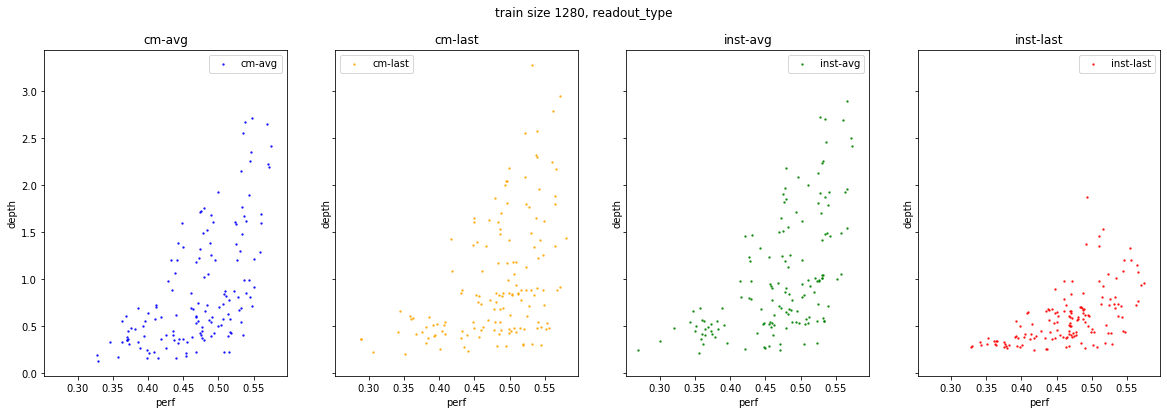

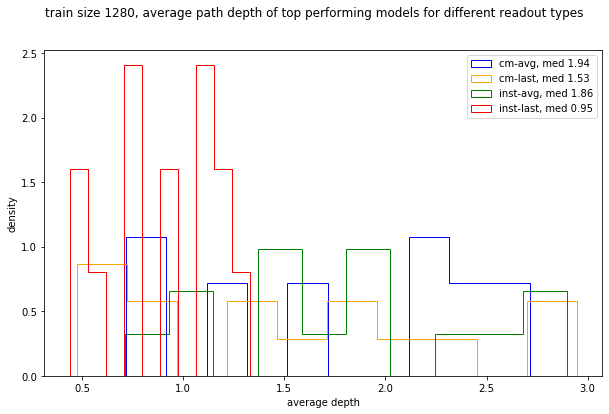

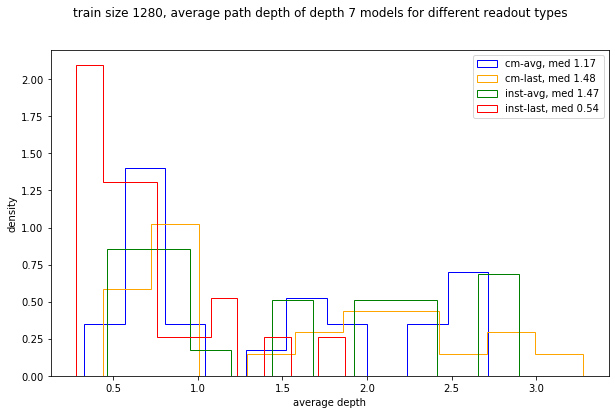

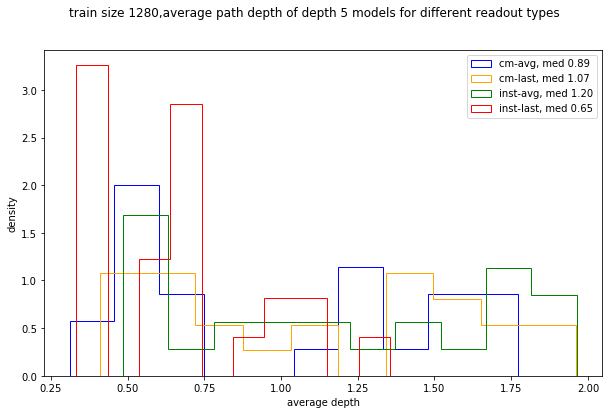

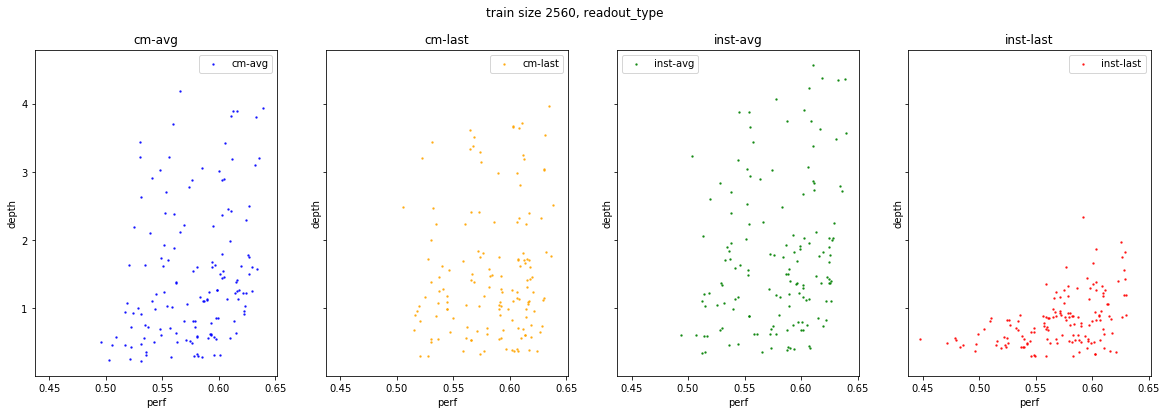

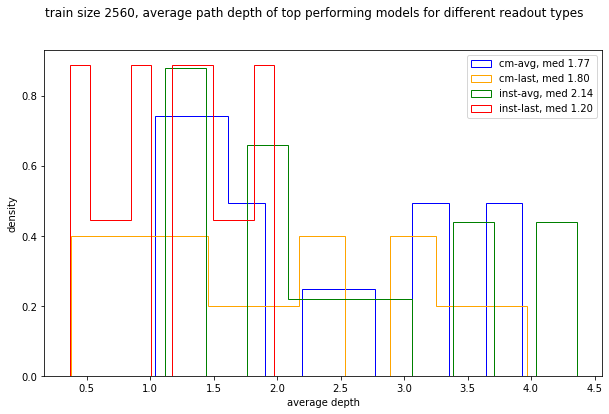

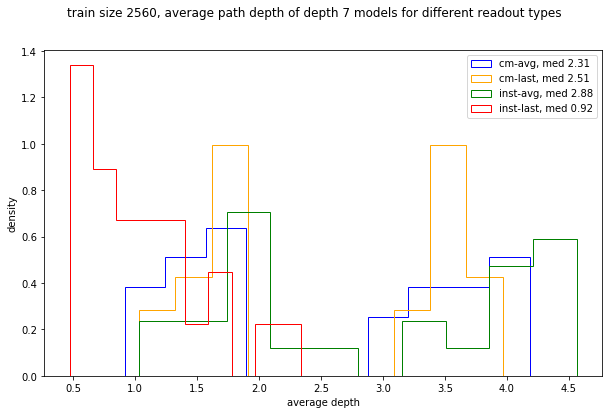

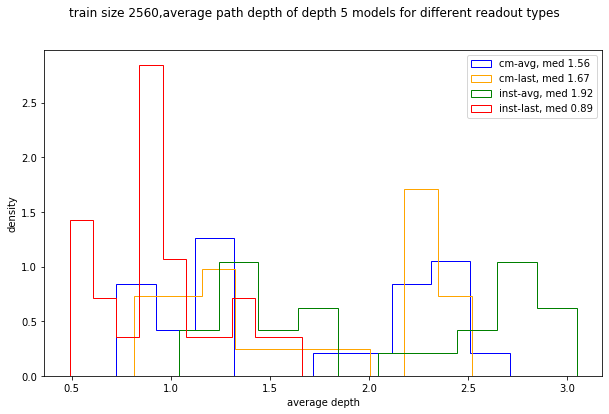

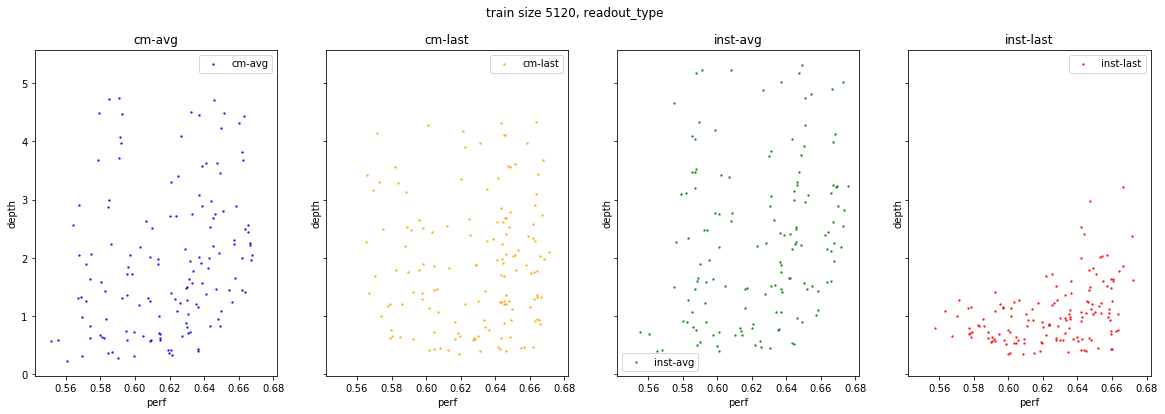

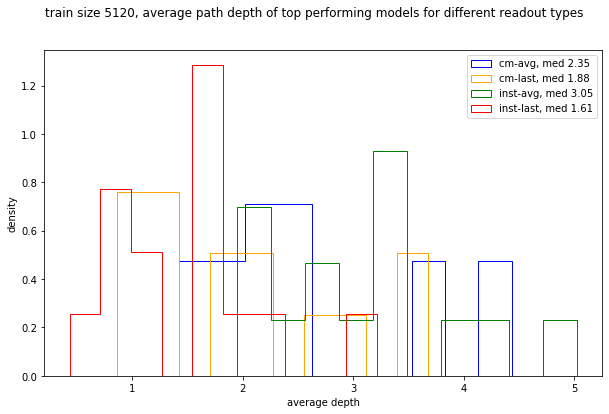

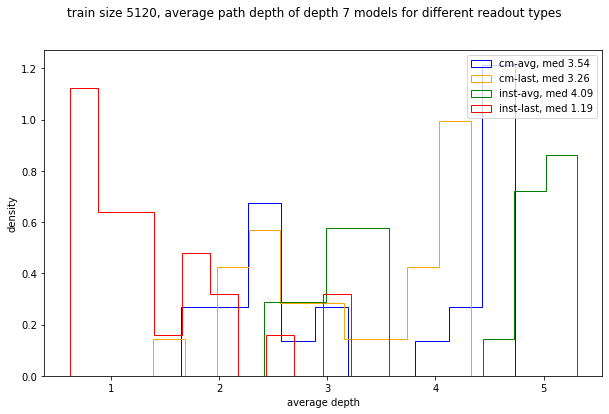

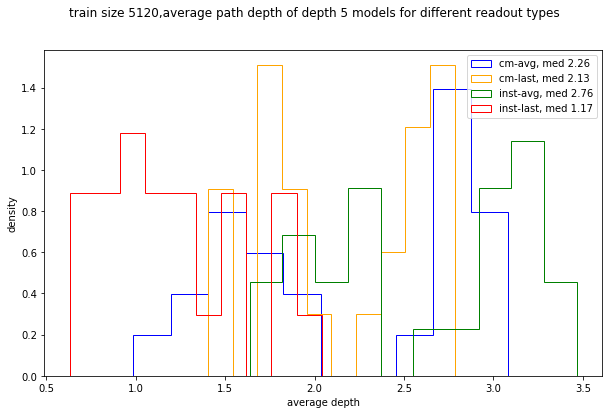

In [27]:
plot_depth_vs_readout_type(df_merged_dict_ref['df_merged'])


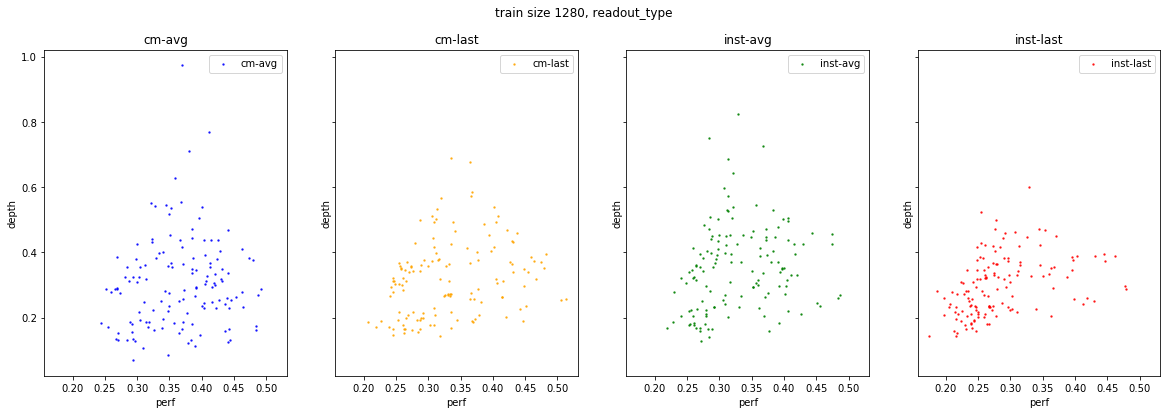

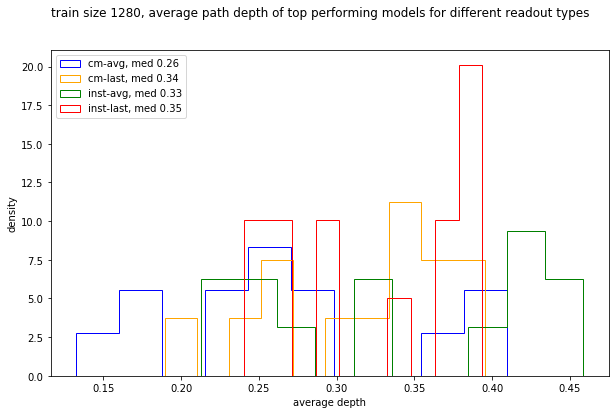

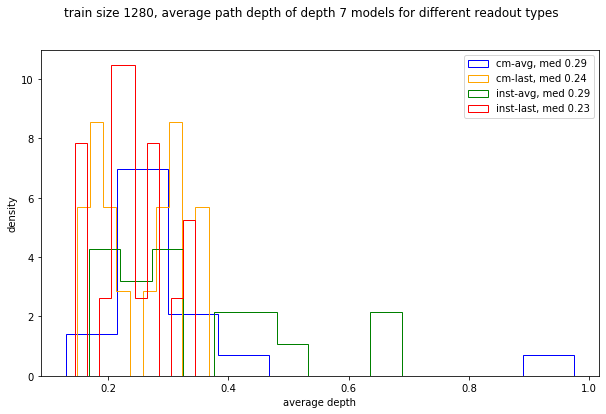

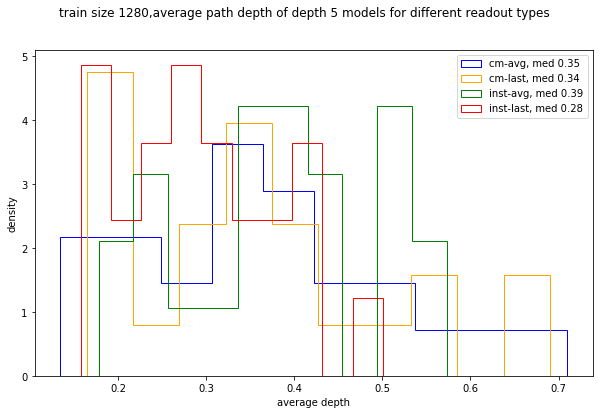

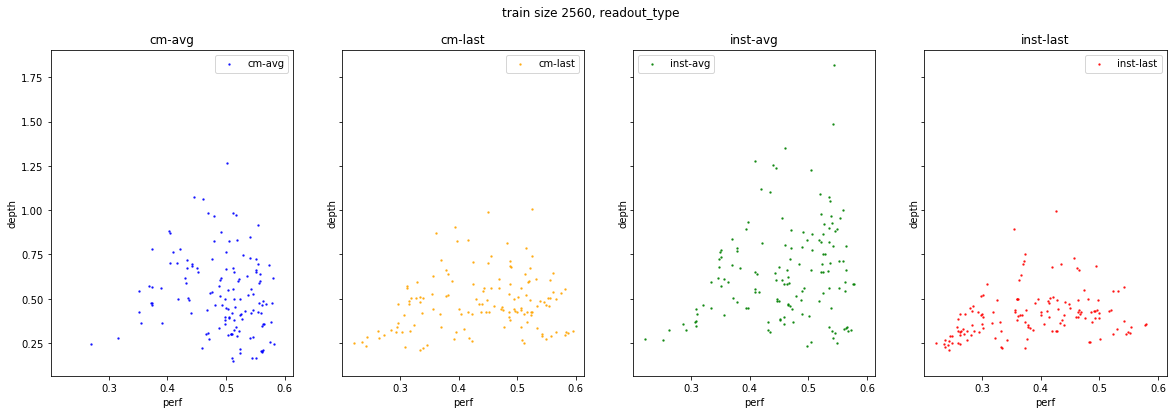

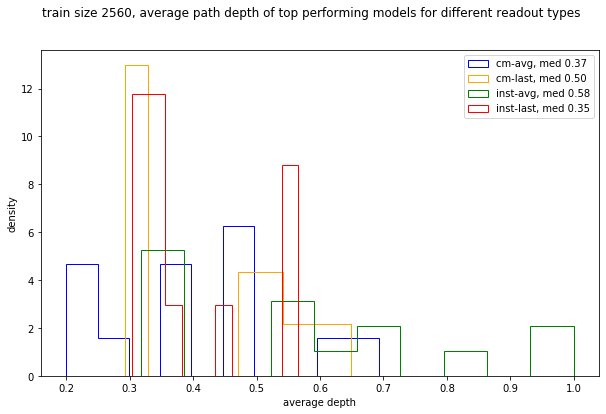

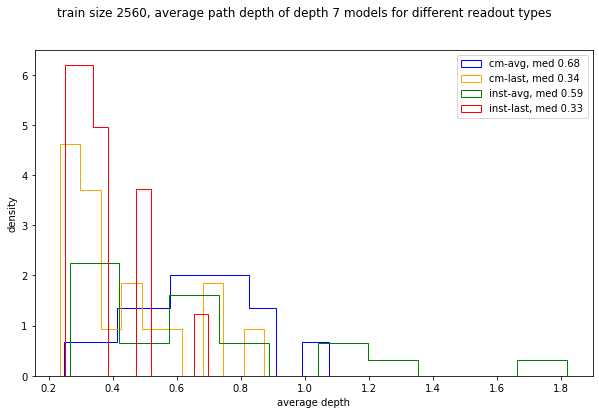

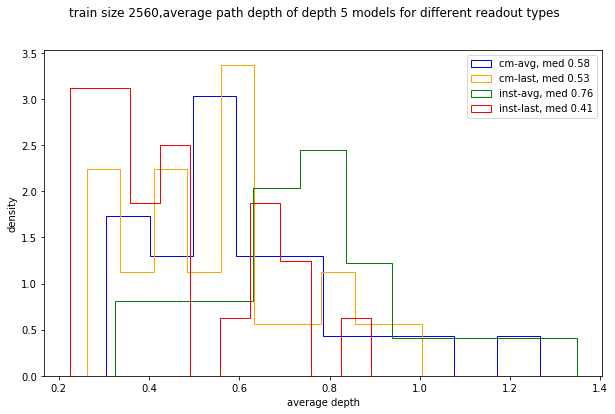

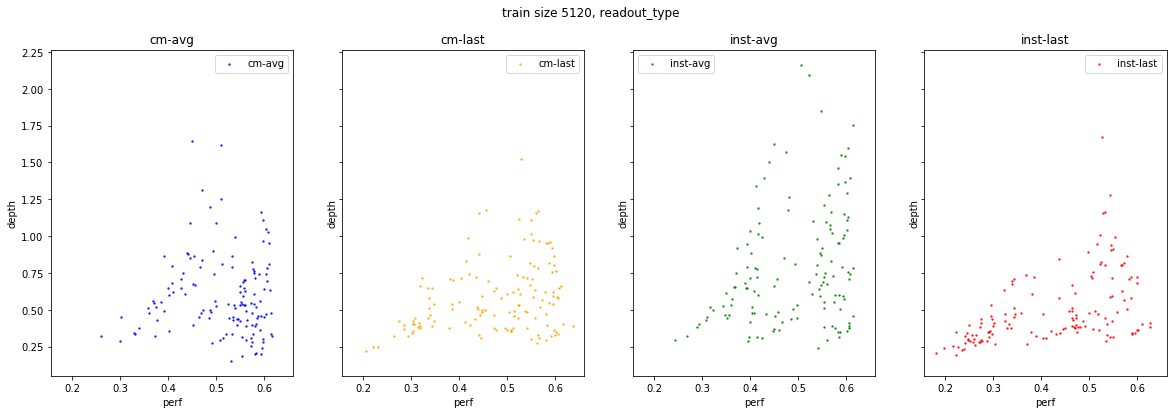

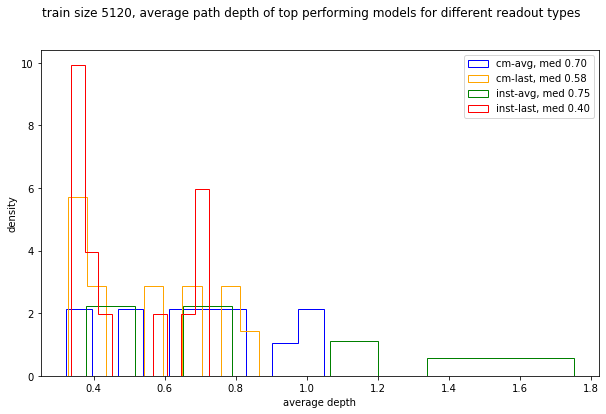

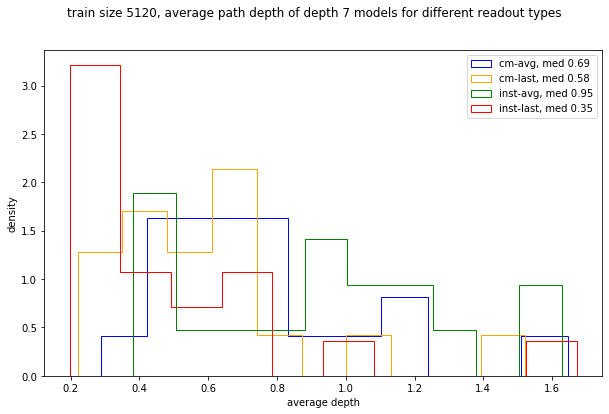

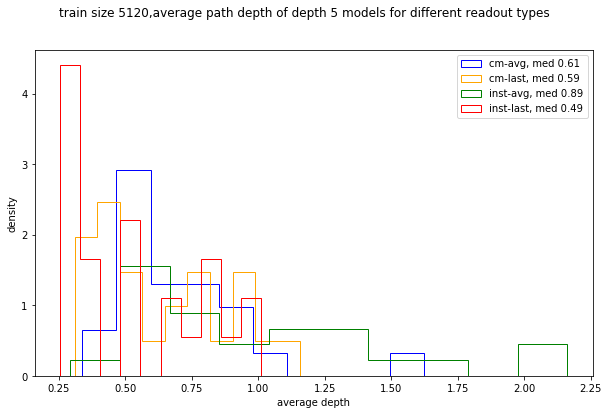

In [28]:
plot_depth_vs_readout_type(df_merged_dict_multipath['df_merged'])

In [29]:
from sklearn.cluster import KMeans

In [30]:
def get_clustering(df_this, num_cluster):
#     print(df_this.shape)
    perf_vec = df_this['cc2_normed_avg_mean'].values
    src_analysis_vec = np.asarray([x.tolist() for x in df_this['source_analysis_vec_mean'].values])
    assert src_analysis_vec.ndim == 2
    assert src_analysis_vec.shape[1] == 8
    
    # do clustering.
    # for each cluster, show cluster size, vec_bars, and spread of performance.
    # 1 dimensional
    y = KMeans(n_clusters=num_cluster, random_state=0).fit_predict(src_analysis_vec)
    
    assert np.array_equal(np.unique(y), np.arange(num_cluster))

    ret = {
        'y': y,
        'perf_vec': perf_vec,
#         'src_analysis_vec': src_analysis_vec,
        'num_cluster': num_cluster,
    }
    
    return ret

In [31]:
from scipy.stats import sem

In [32]:
def clustering_inner(ax, df_merged_this, suffix):
    k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
    std_cluster_list = []
    std_random_list = []
    std_random_list_errbar = []
    # do k-means
    for k in k_list:
        cluster_this = get_clustering(df_merged_this, k)
        # get_avg_inner_std
        avg_inner_std_clustering = get_avg_inner_std(**cluster_this)
        rng_state = np.random.RandomState(seed=0)
        avg_inner_std_random = []
        for idx in range(100):
            # shuffle
            rng_state.shuffle(cluster_this['y'])
            avg_inner_std_random.append(get_avg_inner_std(**cluster_this))
        avg_inner_std_random = np.array(avg_inner_std_random)
        avg_inner_std_random_std = sem(avg_inner_std_random, ddof=0)
        std_cluster_list.append(avg_inner_std_clustering)
        std_random_list.append(avg_inner_std_random.mean())
        std_random_list_errbar.append(avg_inner_std_random_std)

    # plot!!!!
    
    ax.plot(k_list, std_cluster_list, label='clustering based on score vector' + suffix)
    ax.errorbar(k_list, std_random_list, std_random_list_errbar, label='control' + suffix)
    ax.set_xlabel('number of clusters')
    ax.set_ylabel('performance\'s std, averaged over different clusters')
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)

In [33]:
# do some clustering over all readout types (cls=2~7), separately for different training size, and num_layer.

# the goal is to show that the depth distribution have some predictive power.


# how to show that.

# 1. do a k-way clustering. right now let me use kmeans. later maybe some hierarchical clustering is preferred as that will give equal sized 
# 2. control group: randomly suffle k-way clustering results. do this multiple times.

# 3. what to compute: average inner cluster std for 1
#  vs average of average inner cluster std for 2


# do this for multiple ks.


def get_avg_inner_std(*, y, perf_vec, num_cluster):
    assert np.array_equal(np.unique(y), np.arange(num_cluster))
    ret = []
    for idx in range(num_cluster):
        perf_this = perf_vec[y==idx]
        ret.append(perf_this.std()) 
    return np.array(ret).mean()
    

def demonstrate_predicive_power_of_source_analysis_vec(df_merged):
    
    df_merged = df_merged[(df_merged.index.get_level_values('rcnn_bl_cls') >= 2) &(df_merged.index.get_level_values('rcnn_bl_cls') <= 7)]
    
    label_list_train_size = df_merged.index.get_level_values('train_keep').unique()

    
    for train_size in label_list_train_size:
        df_merged_this_train_size = df_merged.xs(train_size, level='train_keep')
        num_layer_list = df_merged_this_train_size.index.get_level_values('num_layer').unique().tolist()
        for num_layer in num_layer_list:
            df_merged_this = df_merged_this_train_size.xs(num_layer, level='num_layer')
            print(train_size, num_layer, df_merged_this.shape)
            
            
            plt.close('all')
            fig, ax = plt.subplots(1, 1, squeeze=True, figsize=(20, 8), sharex=True, sharey=True)
            
            clustering_inner(ax, df_merged_this, '')
            clustering_inner(ax,
                df_merged_this[~df_merged_this.index.get_level_values('readout_type').isin(['inst-last'])],
                             ' no inst-last',
            )
            ax.legend()
            ax.set_title('train size {}, num layer {}'.format(train_size, num_layer))
            plt.show()
            
            
        
        
        

1280 3 (576, 3)


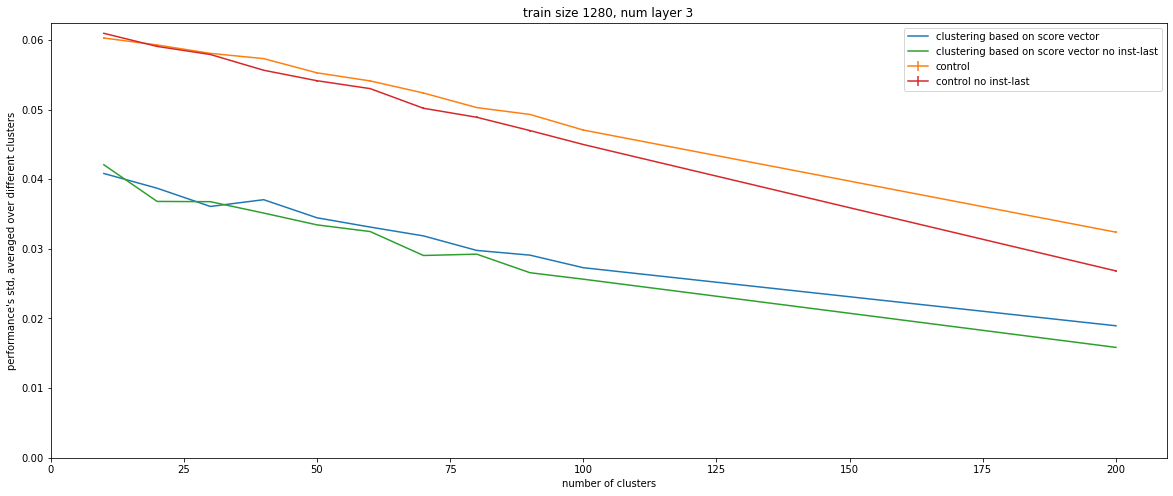

2560 3 (576, 3)


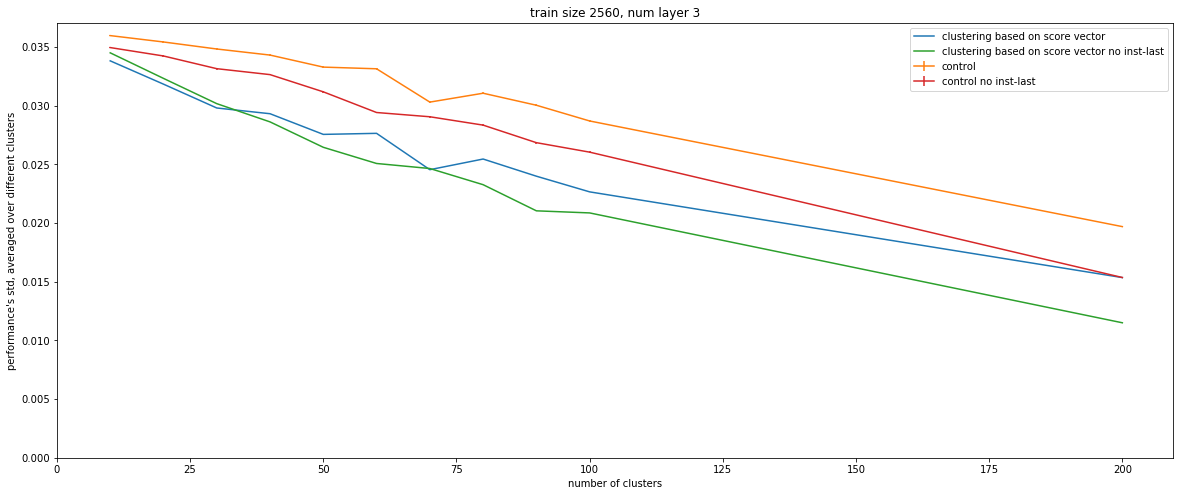

5120 3 (576, 3)


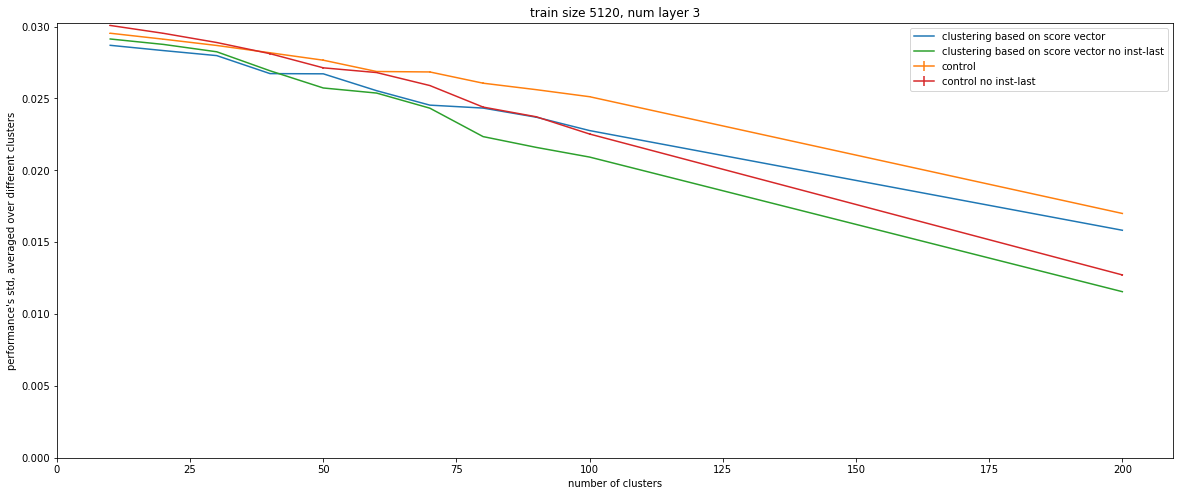

In [34]:
demonstrate_predicive_power_of_source_analysis_vec(df_merged_dict_ref['df_merged'])

1280 3 (549, 3)


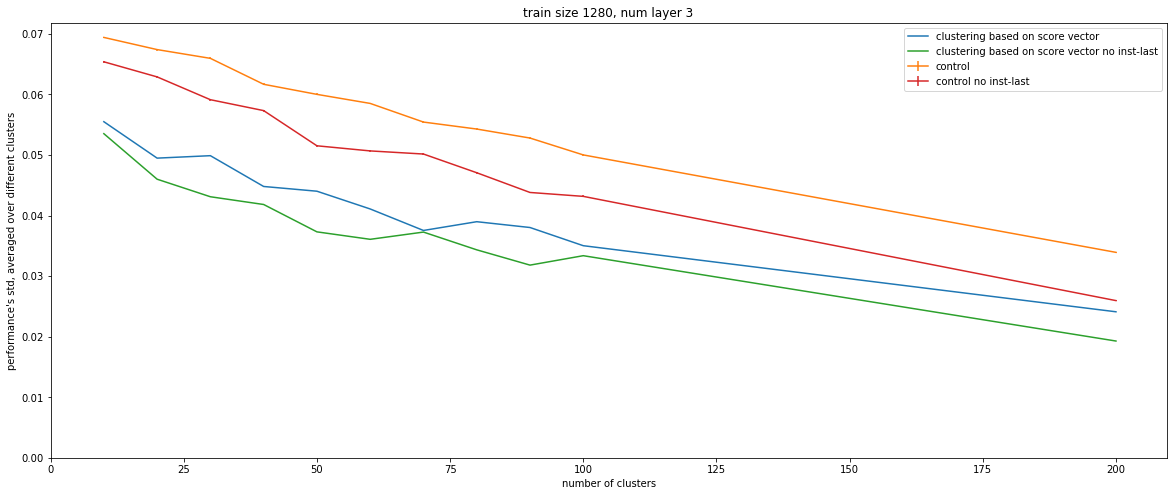

2560 3 (548, 3)


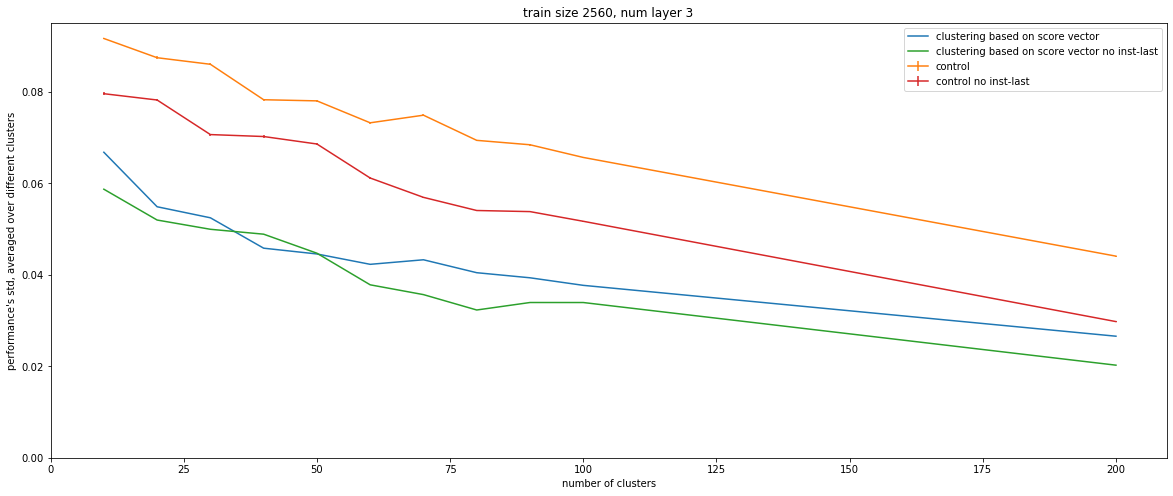

5120 3 (549, 3)


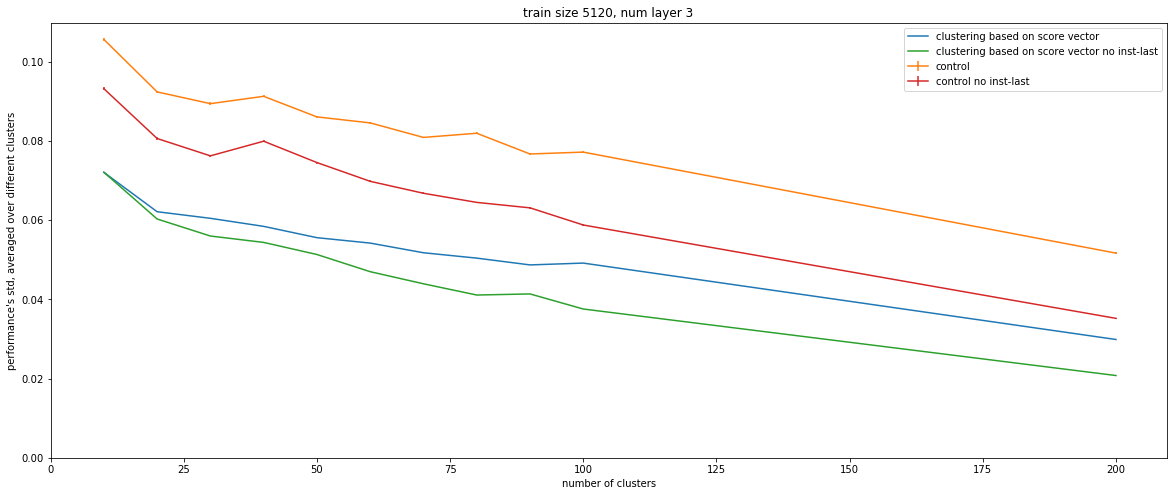

In [35]:
demonstrate_predicive_power_of_source_analysis_vec(df_merged_dict_multipath['df_merged'])